# Convergence analysis

How do you know if a genetic algorithm has converged? This notebook takes the results from `optimization_lake_model_dps.py` and analyses this to assess the convergence. This example ran the optimization for 5 seeds and stored all data in `./data/convergences`. 

## Creating the reference sets
The first step for asesssing the convergence is to create a reference set. The reference set is the Pareto approximate set agains which you compare. In theoretical cases, you can analytically generate the reference set. In most real cases, however, you create the reference set by combining the best results from each of the seeds and redoing an (epsilon) non-dominated sort.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# read all the archives
final_archives = [
    pd.read_csv("./data/convergences/25_final_archive.csv", index_col=0),
    pd.read_csv("./data/convergences/114_final_archive.csv", index_col=0),
    pd.read_csv("./data/convergences/281_final_archive.csv", index_col=0),
    pd.read_csv("./data/convergences/654_final_archive.csv", index_col=0),
    pd.read_csv("./data/convergences/759_final_archive.csv", index_col=0),
]

In [2]:
from ema_workbench import Problem, RealParameter, ScalarOutcome, epsilon_nondominated

# specify the optimization problem
decision_variables = [
    RealParameter("c1", -2, 2),
    RealParameter("c2", -2, 2),
    RealParameter("r1", 0, 2),
    RealParameter("r2", 0, 2),
    RealParameter("w1", 0, 1),
]
objectives = [
    ScalarOutcome("max_p", kind=ScalarOutcome.MINIMIZE),
    ScalarOutcome("utility", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("inertia", kind=ScalarOutcome.MAXIMIZE),
    ScalarOutcome("reliability", kind=ScalarOutcome.MAXIMIZE),
]
problem = Problem("levers", decision_variables, objectives)

# create the reference set
reference_set = epsilon_nondominated(final_archives, [0.1] * len(objectives), problem)

## Runtime information
There are two kinds of data for analysing convergence. The first kind of data is the information collected at runtime about the progress that is being made and potentially about the behavior of the algorithm itself. In case of the dps lake problem example, we have the number of epsilon improvements by nfe, and, since we are using an auto adaptive variator, we have informatipn about the probabilities of the different crossover operators. 


In [3]:
runtime_information = [
    pd.read_csv("./data/convergences/25_runtime_convergence_info.csv", index_col=0),
    pd.read_csv("./data/convergences/114_runtime_convergence_info.csv", index_col=0),
    pd.read_csv("./data/convergences/281_runtime_convergence_info.csv", index_col=0),
    pd.read_csv("./data/convergences/654_runtime_convergence_info.csv", index_col=0),
    pd.read_csv("./data/convergences/759_runtime_convergence_info.csv", index_col=0),
]

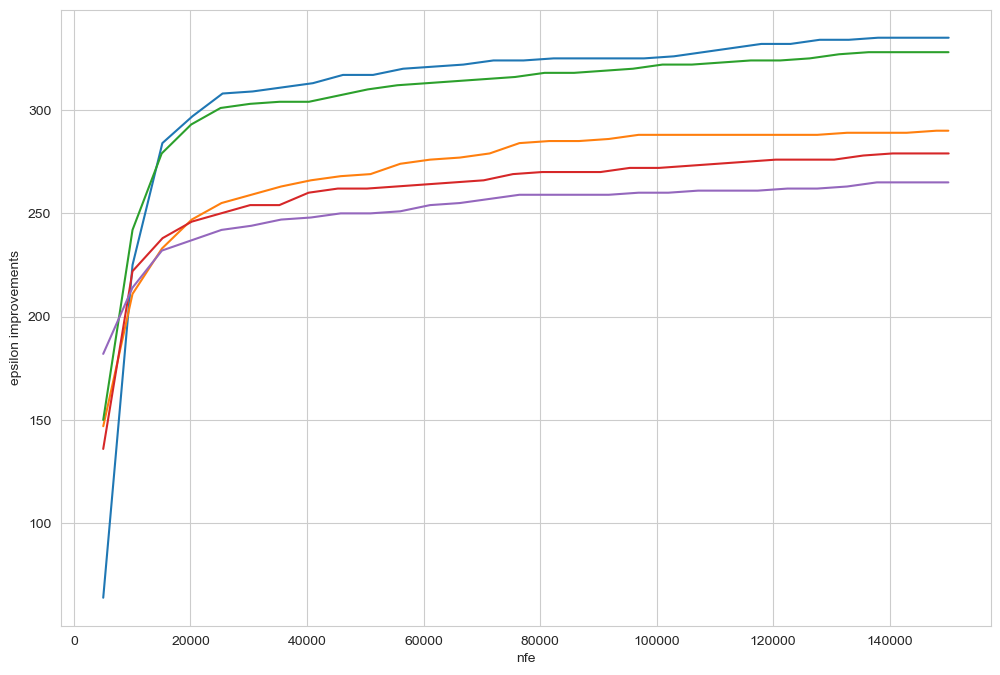

In [4]:
fig, ax = plt.subplots()

for entry in runtime_information:
    ax.plot(entry.nfe, entry.epsilon_progress)

ax.set_xlabel("nfe")
ax.set_ylabel("epsilon improvements")
plt.show()

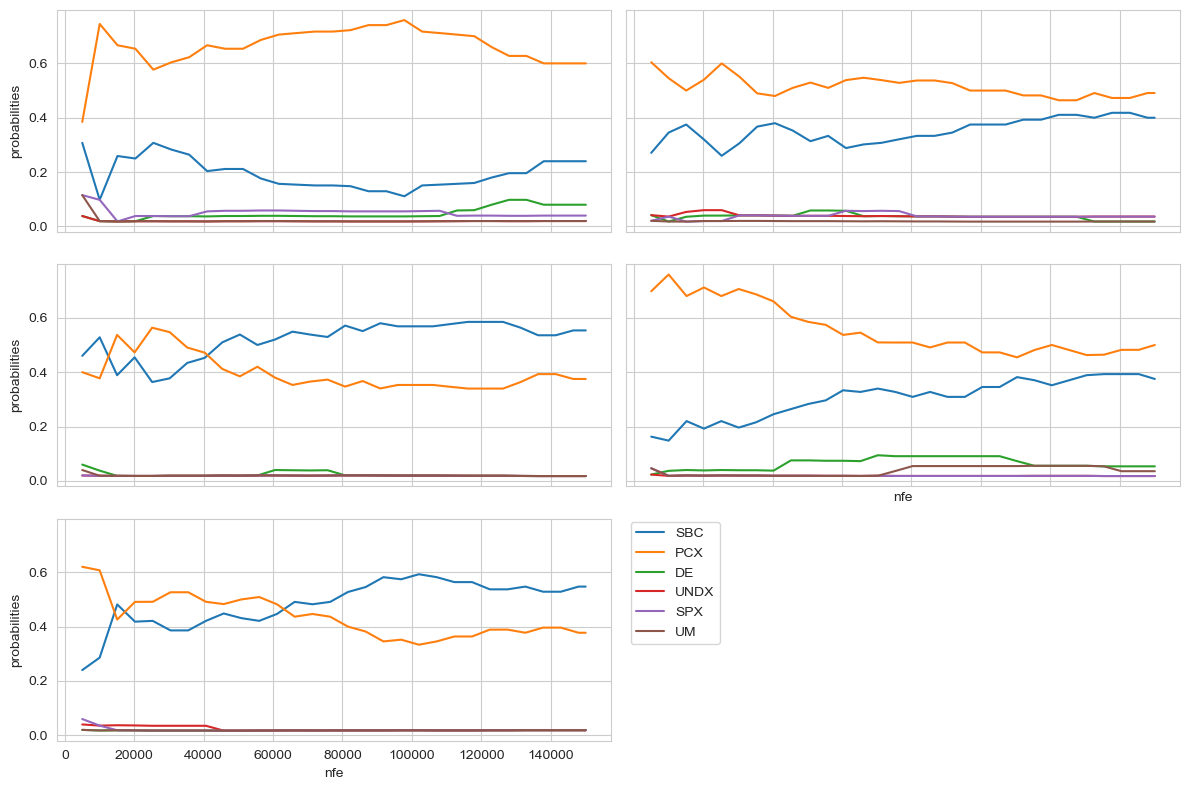

In [5]:
from matplotlib.colors import TABLEAU_COLORS
from matplotlib.lines import Line2D

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True, sharey=True)

for ax, data in zip(axes.flatten(), runtime_information):
    ax.plot(data.nfe, data.SBX, label="SBX")
    ax.plot(data.nfe, data.PCX, label="PCX")
    ax.plot(data.nfe, data.DifferentialEvolution, label="Differential Evolution")
    ax.plot(data.nfe, data.UNDX, label="UNDX")
    ax.plot(data.nfe, data.SPX, label="SPX")
    ax.plot(data.nfe, data.UM, label="UM")

axes[-1, -1].axis("off")

colors = list(TABLEAU_COLORS.values())

custom_lines = [
    Line2D([0], [0], color=colors[0], label="SBC"),
    Line2D([0], [0], color=colors[1], label="PCX"),
    Line2D([0], [0], color=colors[2], label="DE"),
    Line2D([0], [0], color=colors[3], label="UNDX"),
    Line2D([0], [0], color=colors[4], label="SPX"),
    Line2D([0], [0], color=colors[5], label="UM"),
]
fig.legend(handles=custom_lines, bbox_to_anchor=(0.61, 0.35))

for ax in axes[:, 0]:
    ax.set_ylabel("probabilities")

axes[2, 0].set_xlabel("nfe")
axes[1, 1].set_xlabel("nfe")

plt.tight_layout()
plt.show()

## Convergence metrics
The second kind of convergence analysis involves analysing the identified solutions at different points over the course of the evolutionary process. For this, we can analyse the archives that are stored in a tarball.

For more detail on these metrics, see the following references:
* Generational distance [van Veldhuizen et al (1999)](https://dl.acm.org/doi/10.1145/298151.298382)
* Inverted generational distance[Bezerra et al (2017](https://dl.acm.org/doi/10.1007/978-3-319-54157-0_3)
* Additive epsilon indicator and hypervolume [Zitzler & Thiele (1999)](https://ieeexplore.ieee.org/document/797969)
* Hypervolume [Fonseca et al (2006)](https://ieeexplore.ieee.org/document/1688440)
* Putting it al together: [Zatarain Salazar et al. (2024)](https://www.tandfonline.com/doi/full/10.1080/0305215X.2024.2381818)


In [6]:
from ema_workbench import load_archives

In [7]:
all_archives = [
    load_archives("./data/convergences/25_lake_model_dps_archive.tar.gz"),
    load_archives("./data/convergences/114_lake_model_dps_archive.tar.gz"),
    load_archives("./data/convergences/281_lake_model_dps_archive.tar.gz"),
    load_archives("./data/convergences/654_lake_model_dps_archive.tar.gz"),
    load_archives("./data/convergences/759_lake_model_dps_archive.tar.gz"),
]

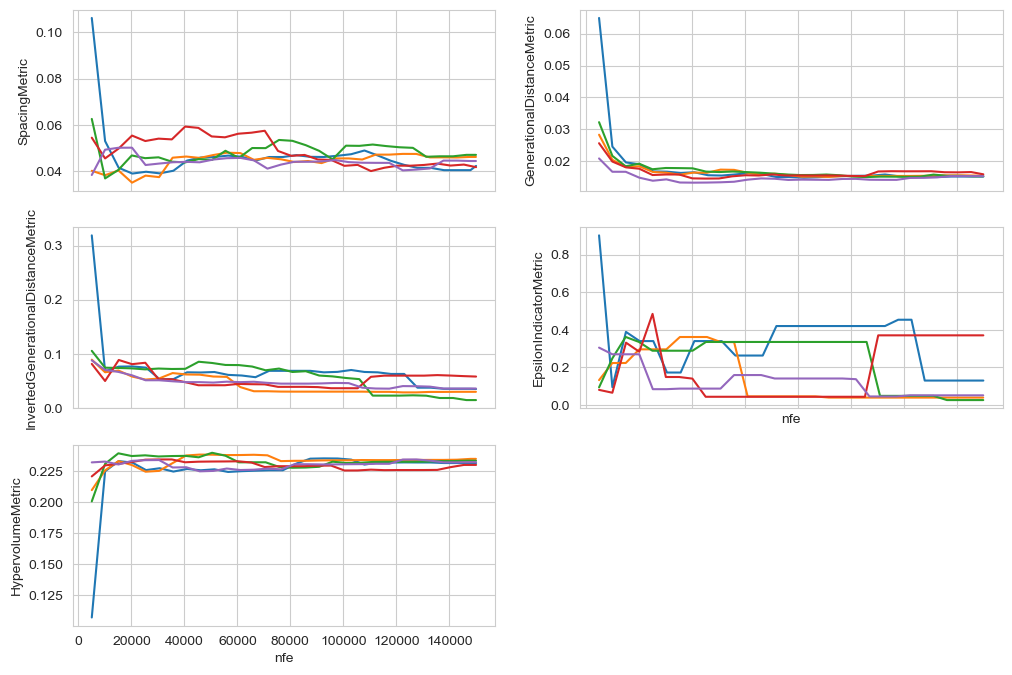

In [8]:
from ema_workbench import (
    EpsilonIndicatorMetric,
    GenerationalDistanceMetric,
    HypervolumeMetric,
    InvertedGenerationalDistanceMetric,
    SpacingMetric,
)

fig, axes = plt.subplots(ncols=2, nrows=3, sharex=True)
axes[-1, -1].axis("off")

for ax, metric_class in zip(
    axes.flatten(),
    [
        SpacingMetric,
        GenerationalDistanceMetric,
        InvertedGenerationalDistanceMetric,
        EpsilonIndicatorMetric,
        HypervolumeMetric,
    ],
):
    metric = metric_class(reference_set, problem)

    for entry in all_archives:
        scores = []
        for nfe, archive in entry:
            score = metric.calculate(archive)
            scores.append((nfe, score))

        scores = np.asarray(scores)

        ax.plot(scores[:, 0], scores[:, 1])
    ax.set_ylabel(metric.__class__.__name__)

axes[2, 0].set_xlabel("nfe")
axes[1, 1].set_xlabel("nfe")

plt.show()

The computational cost of some of these metrics can become substantial. In particular, hypervolume scales badly with both the number of solutions in the archive and the number of objectives. The metrics used here rely on platypus-opt, which implements all metrics in pure python. However, [deap](https://deap.readthedocs.io/en/master/) ships with a hypervolume calculation implemented in C, which is substantially faster. Below is a quick illustration on how to use this implementation to produce the same results as produced by platypus. 

In short, we need to do several things. First, the data needs to be normalized on unit interval. Next, the hypervolume calculation in deap assumes minimization across all objectives, so we need to flip the direction for the columns that assume maximization. Since the data is normalized on unit interval, this can easily be achied by using 1 (the normalized maximum value) minus the actual value. 

In [9]:
from deap.tools._hypervolume import hv
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()  # set up the scaler
scaler.fit(
    reference_set.values[:, 5::]
)  # use the reference set as minimum and maximum, this mimics platypus.


def handle_directions(data, problem):
    """Handle the optimization directions, and transform so all columsn reflect minimization."""
    data = data.copy()
    for i in range(data.shape[1]):
        column = data[:, i]
        if problem.directions[i].value == 1:  # maximze
            data[:, i] = 1 - column
    return data


def transform_data(data, scaler, problem):
    """Transform the archive into a the format required by deap."""
    data = data.values[:, problem.nvars : :]

    # scale data
    transformed_data = scaler.transform(data)

    # handle directions
    transformed_data = handle_directions(transformed_data, problem)

    return transformed_data

We have now all the pieces we need to calculate hypervolume with deap. You can compare this plot to the one produces earlier and check yourself that the results are the same.

As a last tip: if you still run into runtime concerns, its trivial to use a [ProcessPoolExecutor](https://docs.python.org/3/library/concurrent.futures.html#processpoolexecutor) to parallelize the hypervolume calculations.

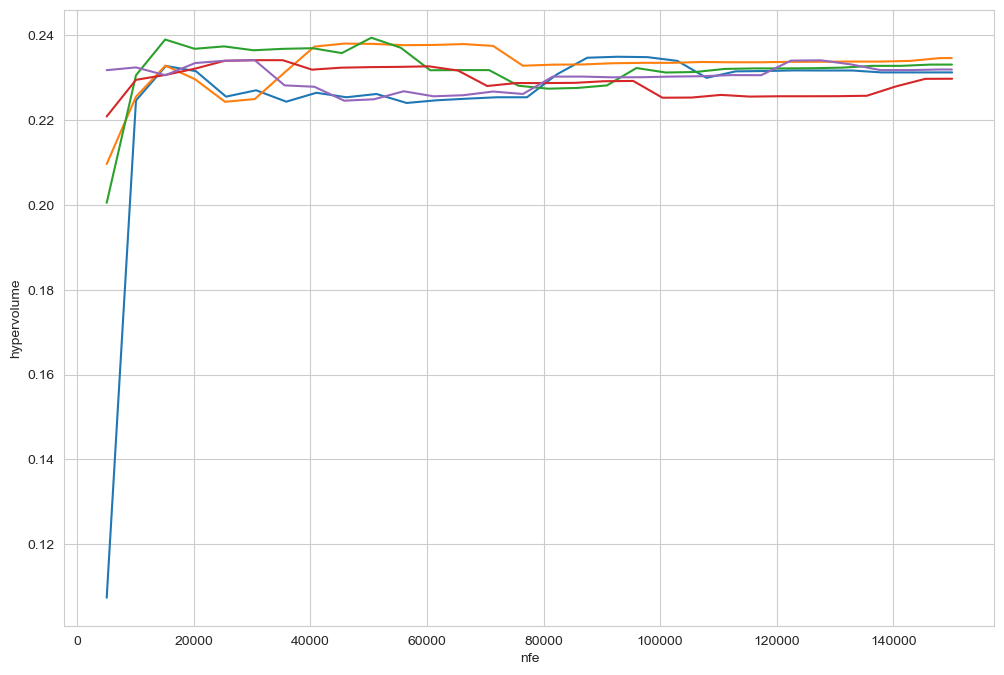

In [10]:
fig, ax = plt.subplots()

for entry in all_archives:
    scores = []
    for nfe, archive in entry:
        transformed_archive = transform_data(archive, scaler, problem)
        score = hv.hypervolume(transformed_archive, np.ones((problem.nobjs,)))
        scores.append((nfe, score))

    scores = np.asarray(scores)

    ax.plot(scores[:, 0], scores[:, 1])

ax.set_xlabel("nfe")
ax.set_ylabel("hypervolume")

plt.show()